In [9]:
import os,sys
import numpy as np
import sympy as sym
import sys
sym.init_printing()
sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram.scipy import ScipyPDReactiveODE
from tcg_slb.phasediagram.base import PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *
import pickle
from pathlib import Path

reference= 'ec_reactions'

In [31]:
def get_reaction(lib):
    pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
    sys.path.append(os.path.join(os.path.pardir, 'database', 'install', lib, 'lib', 'python'+pv, 'site-packages/')) # the final slash is necessary!
    tcgdb = __import__('py_'+lib)
    func = getattr(tcgdb,lib) 
    rxn = func() # <-- this should work!
    return rxn

def get_pickle_path(rxnObj): 
    return Path('output', rxnObj.name() + '.pickle')

def load_grid(reactionObject):
    filename = get_pickle_path(reactionObject)
    with open(filename, 'rb') as pfile:
        bdfgrid = pickle.load(pfile)
    return bdfgrid

def save_grid(bdfgrid, reactionObject):
    filename = get_pickle_path(reactionObject)
    filename.parent.mkdir(exist_ok=True, parents=True)
    with open(filename, 'wb+') as pfile:
        pickle.dump(bdfgrid, pfile)

def solve_reaction_grid(reactionObject, mi0=None, Cik0=None, T_range=None, p_range=None, filename=None, reload=False, save=False, odeClass=ScipyPDReactiveODE):
    if reload:
        return load_grid(reactionObject)

    i0 = 2 # doesn't matter as long as you pass cik0
    end = 1e5 # end time

    bdfgrid = PDReactiveGrid()

    bdfgrid.solve(reactionObject, ScipyPDReactiveODE, i0, ['T', 'p'], T_range, p_range, end, Cik0=Cik0, mi0=mi0)

    if save:
        save_grid(bdfgrid, reactionObject)

    return bdfgrid

def plot_reaction_grid(rxn, bdfgrid, plot_phases=True,figure_background=None, figure_xlim=[273.15,1273.15], figure_ylim=[0.0,5.0]):
    import matplotlib.pyplot as plt

    def decorate(pdrgd):
        def new_setup_axes(self,axi):
            if(figure_background is not None):
                img = plt.imread(figure_background)
                ip = axi.imshow(img)
                axi.axis('off')
                ax = axi.inset_axes([0.001,0.006,0.995,0.991])
                ax.patch.set_alpha(0.0)
            
            ax = plt.gca()
            ax.set_xlabel("Temperature (K)")
            ax.set_ylabel("Pressure (GPa)")
            ax.set_xlim(figure_xlim)
            ax.set_ylim(figure_ylim)
            return ax
    
        #replace the display with newdisplay
        pdrgd.setup_axes = new_setup_axes
    
        #return the modified student 
        return pdrgd

    bdfdiag = decorate(PDReactiveGridDiagnostics)(rxn,bdfgrid) 
    s=bdfdiag.plot_rho()
    s.set_clim([25., 35.])
    s.set_cmap('jet')

    if plot_phases:
        bdfdiag.plot_phases()
    return bdfdiag

def run_reaction(rxnName=None, mi0=None, Cik0=None, t_range=None, p_range=None, reload=False, save=False,t0=900,p0=2.0):

    rxn = get_reaction(rxnName)

    # initial temperature, pressure and phase volume fraction
    Ti = t0 # kelvin
    pi = GPa2Bar(p0) # bars

    try:
        ode = ScipyPDReactiveODE(rxn)
        end_t = 1000.0
        ode.solve(Ti,pi,mi0,Cik0,end_t)
        display(ode.stime)
        display(ode.final_phases(1.e-2))
        ode.plot()
    except:
        pass

    grid = solve_reaction_grid(rxn, mi0=mi0, Cik0=Cik0, T_range=t_range, p_range=p_range, reload=reload, save=save)
    plot_reaction_grid(rxn,grid, plot_phases=True)
    return rxn, grid

In [28]:
X_Mg_garnet = 9.888
X_Ca_garnet = 10.549
X_Fe_garnet = 16.369
X_tot_garnet = X_Mg_garnet+X_Ca_garnet+X_Fe_garnet

X_py = X_Mg_garnet/X_tot_garnet
X_alm = X_Fe_garnet/X_tot_garnet
X_gr = X_Ca_garnet/X_tot_garnet

print(X_py, X_alm, X_gr)

X_Na_cpx = 6.326

X_Mg_cpx = 9.451
N_Mg_cpx = 0.498

X_Ca_cpx = 14.948
N_Ca_cpx = 0.566

X_Fe_cpx = 2.304
N_Fe_cpx = 0.068

X_Al_cpx = 10.407

X_tot_cpx = X_Na_cpx + X_Mg_cpx + X_Ca_cpx + X_Fe_cpx + X_Al_cpx

N_Ca_di = N_Mg_cpx
X_Ca_di = (N_Ca_di / N_Ca_cpx) * X_Ca_cpx
X_Ca_he = X_Ca_cpx - X_Ca_di

X_di = (X_Mg_cpx + X_Ca_di) / X_tot_cpx
X_jd = (X_Na_cpx + X_Al_cpx) / X_tot_cpx
X_he = 1 - X_di - X_jd

print(X_di, X_jd, X_he)

0.26865185024180843 0.44473727109710376 0.28661087866108786
0.5203777329514817 0.38523344691039685 0.09438882013812144


(array(['Clinopyroxene_slb_ph', 'Quartz_slb_ph', 'Garnet_slb_ph',
        'Kyanite_slb_ph'], dtype='<U20'),
 array(['cpx', 'qtz', 'gt', 'ky'], dtype='<U3'))

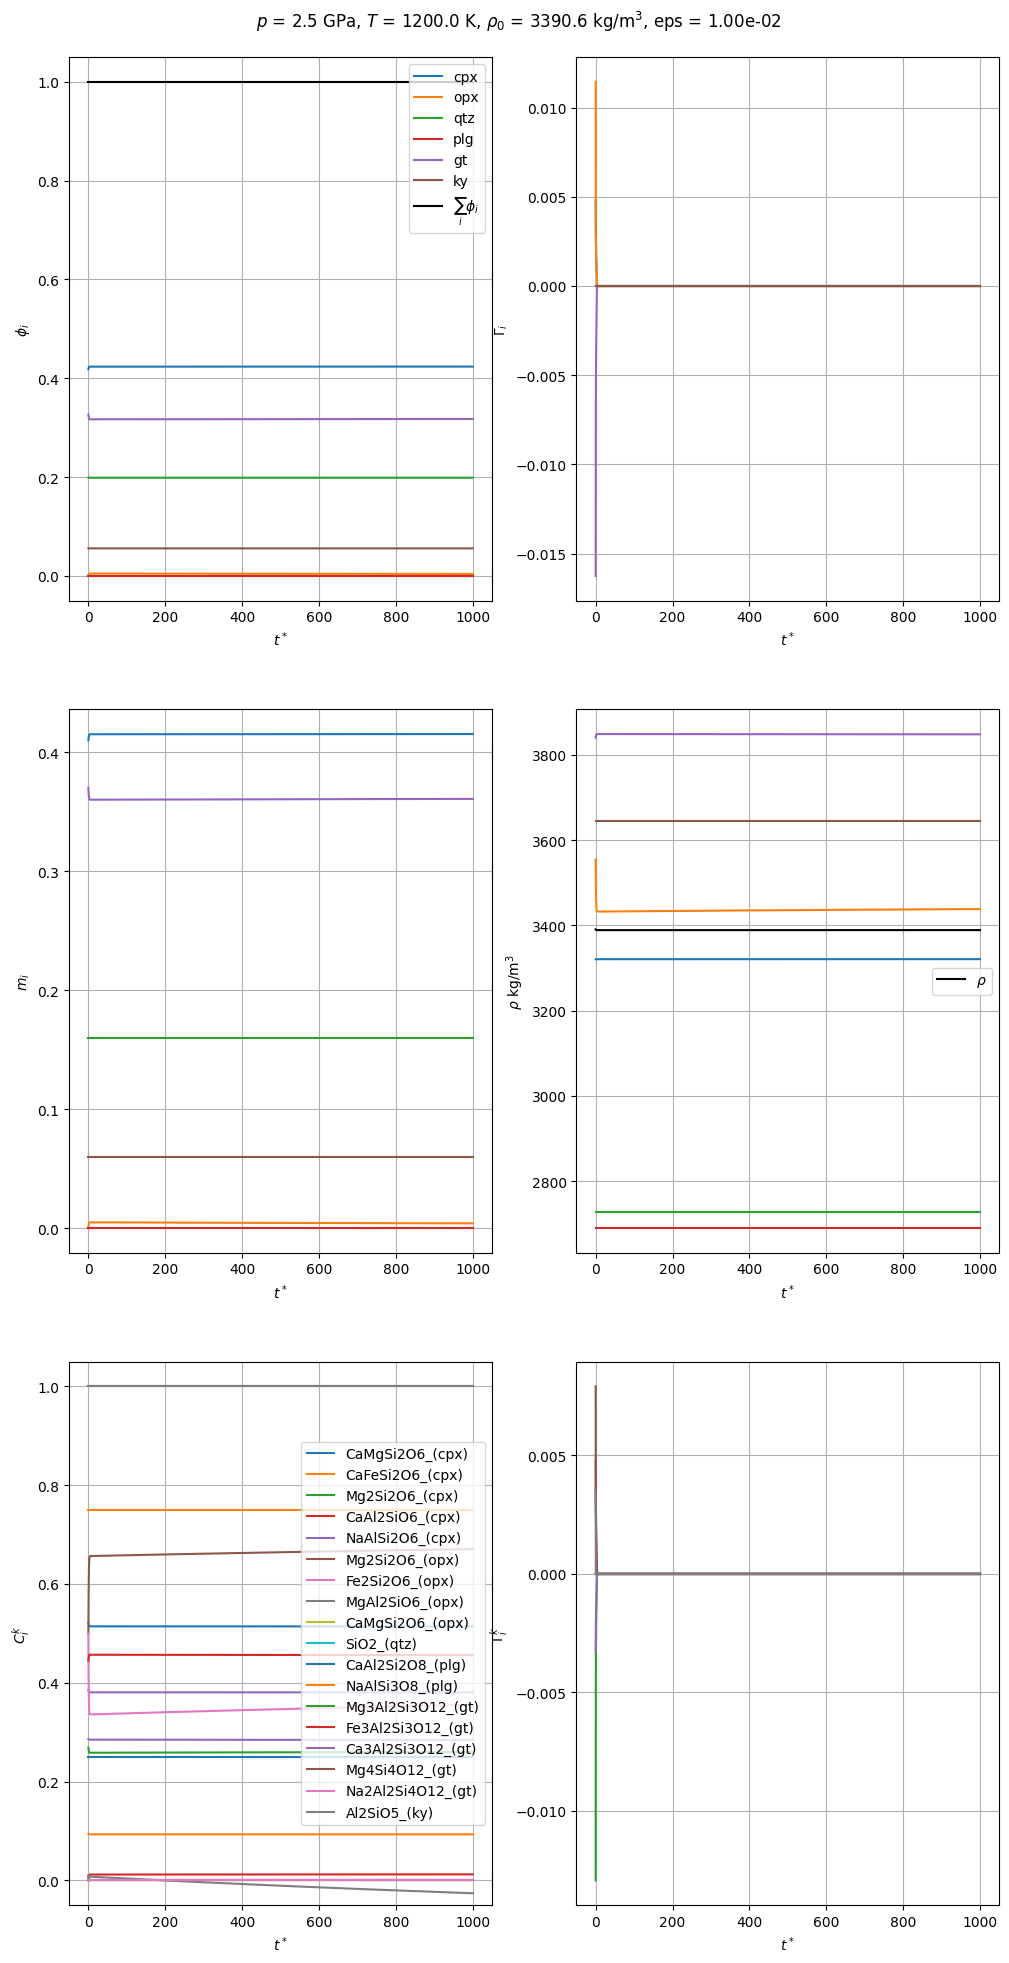

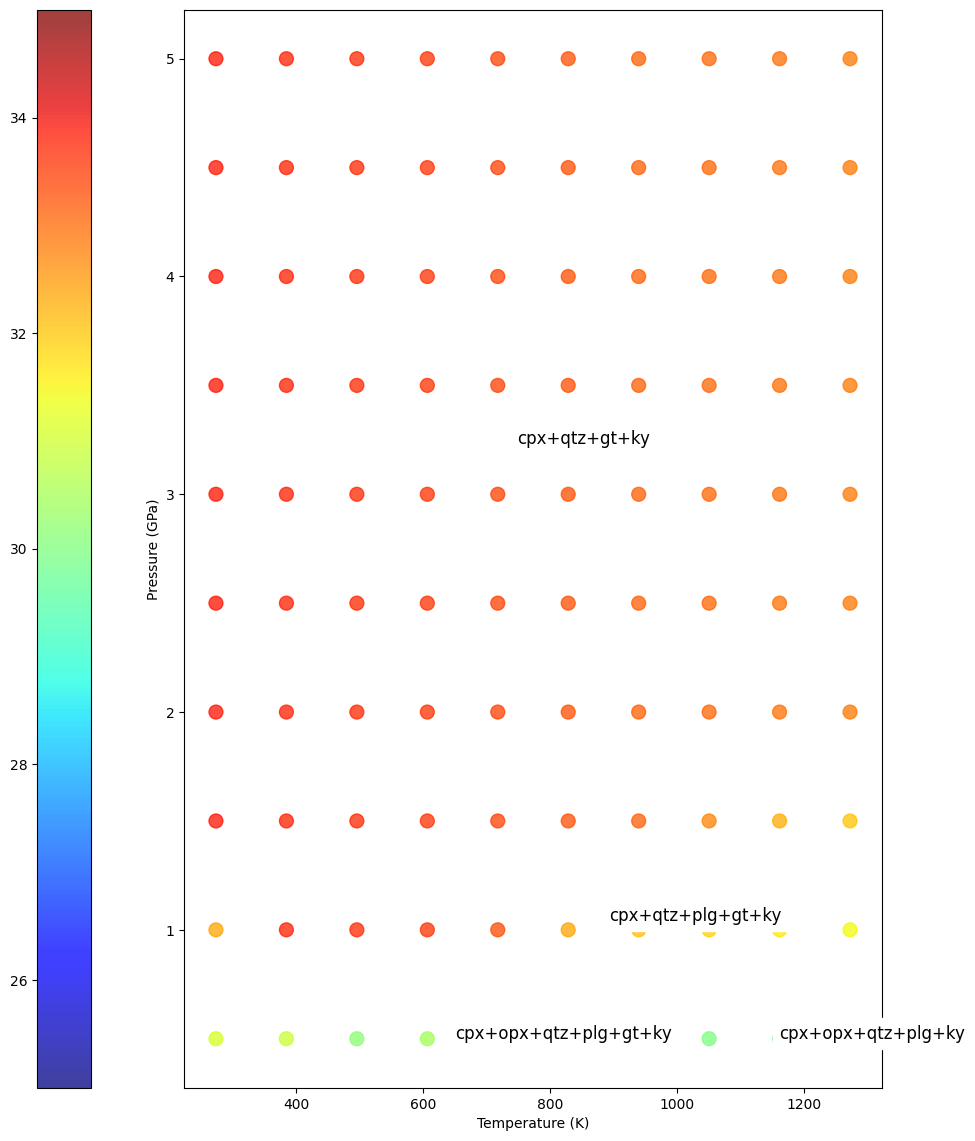

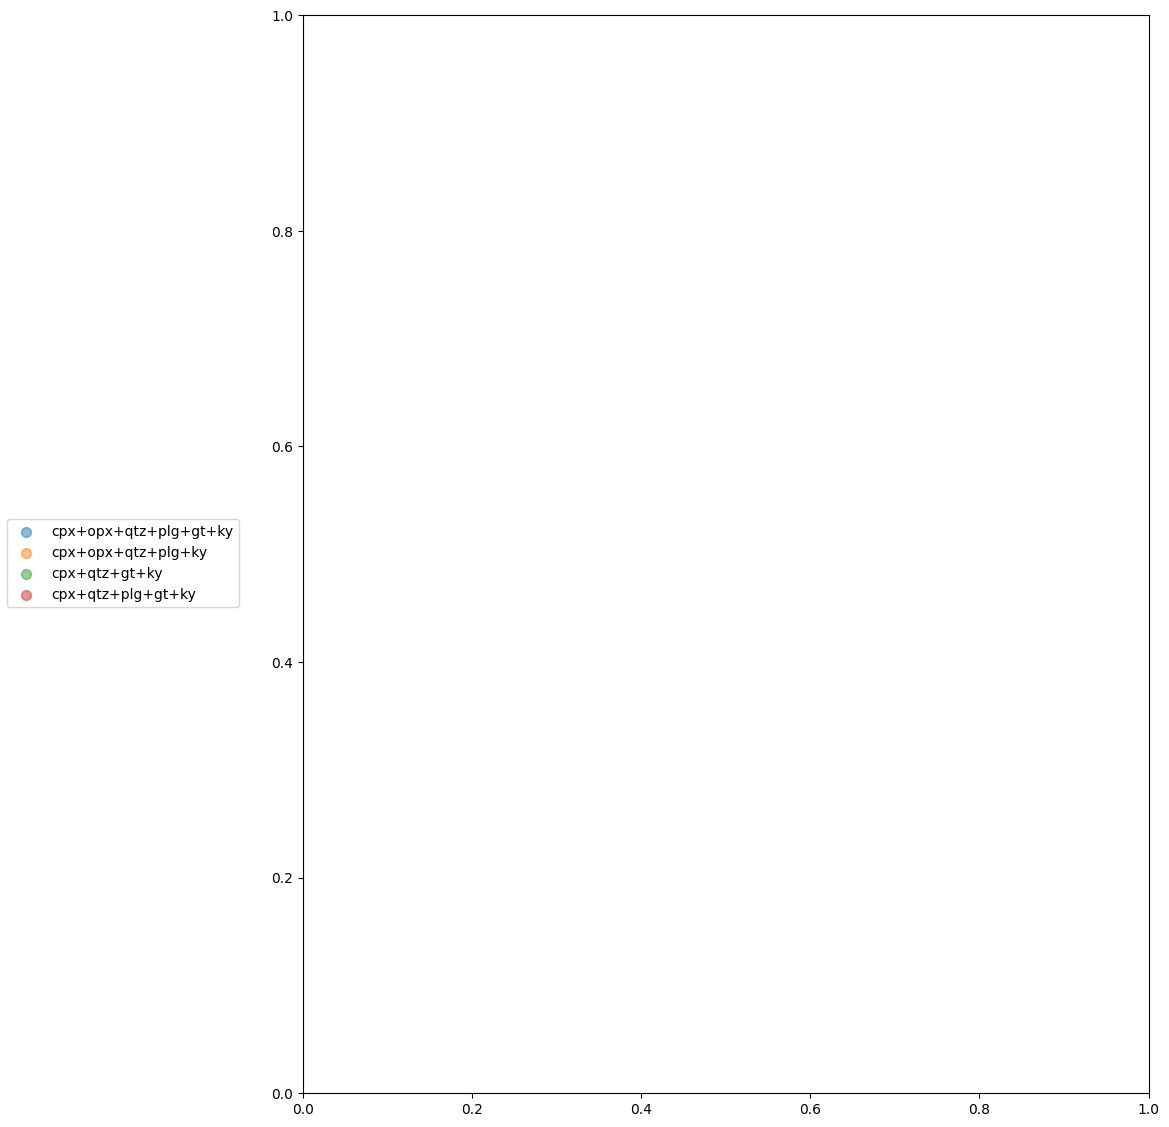

In [30]:
# Simple eclogite using TCG's Stixrude database

Tmin = 273
Tmax = 1273
nT = 100

Pmin = 0.5
Pmax = 5.0
nP = 100

T = np.linspace(Tmin, Tmax, nT)
P = np.linspace(Pmin, Pmax, nP)

phases = [
    'Clinopyroxene',
    'Orthopyroxene',
    'Quartz',
    'Feldspar', 
    'Garnet', 
    'Kyanite',
]

ems = [
    'Diopside', 'Hedenbergite', 'Clinoenstatite', 'CaTschermaks', 'Jadeite',
    'Enstatite', 'Ferrosilite', 'MgTschermaks', 'OrthoDiopside',
    'Quartz',
    'Anorthite','Albite',
    'Pyrope', 'Almandine', 'Grossular', 'MgMajorite', 'NaMajorite',
    'Kyanite'
]

# mass fractions of the phases

# initialize with eclogitic composition

# 40% cpx, 35% garnet, 15% quartz, 5% kyanite

# Mg# should be around 50

mi0 = np.asarray([
    0.40, # cpx
    0.00, # opx
    0.20, # quartz
    0.00, # feldspar
    0.33, # garnet
    0.07 # kyanite
])

# mass fractions of the end-members
# note: * = thermodynamic endmember, set to zero
Cik0 = np.asarray([
    0.25, 0.25, 0., 0., 0.5, # di, hed, *cEn, *cats, jd
    0.5, 0.5, 0., 0., # en, fs, *mats, *oDi
    1., # quartz
    0.25, 0.75, # an, ab
    0.4, 0.4, 0.2, 0., 0., # py, alm, gr, *mgmaj, *namaj
    1., # ky
])

rxn, grid = run_reaction(
    "ec_simple_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=T,
    p_range=P,
    t0=1200,
    p0=2.5,
    reload=True,
    save=False
)

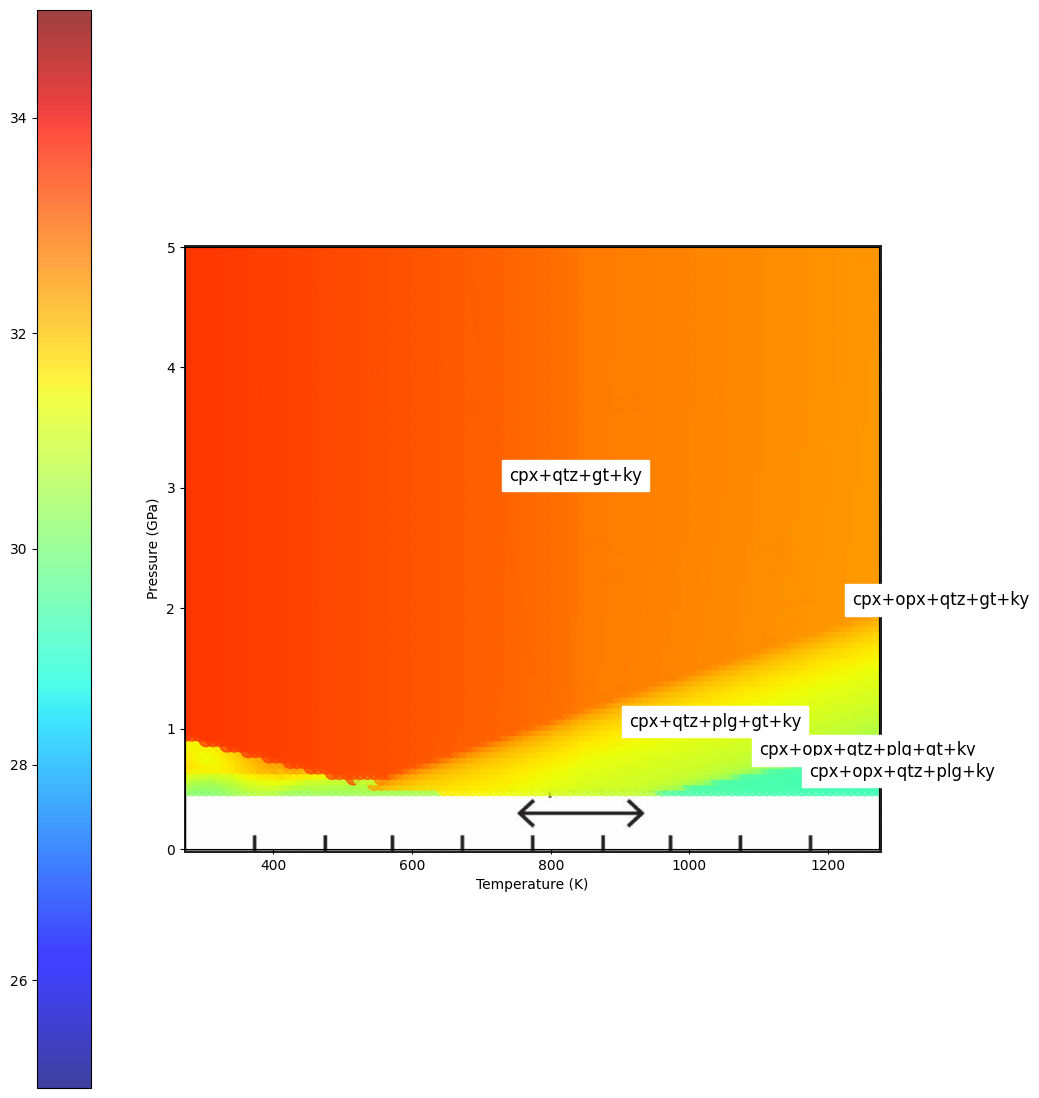

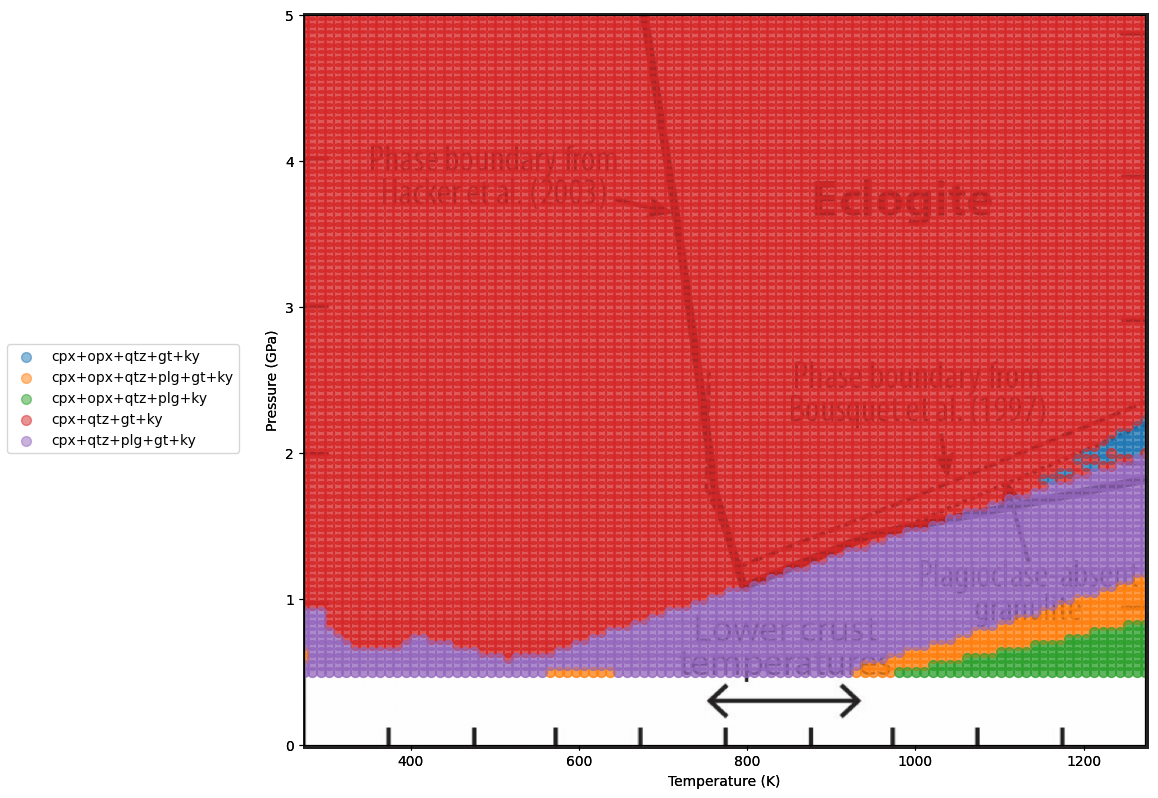

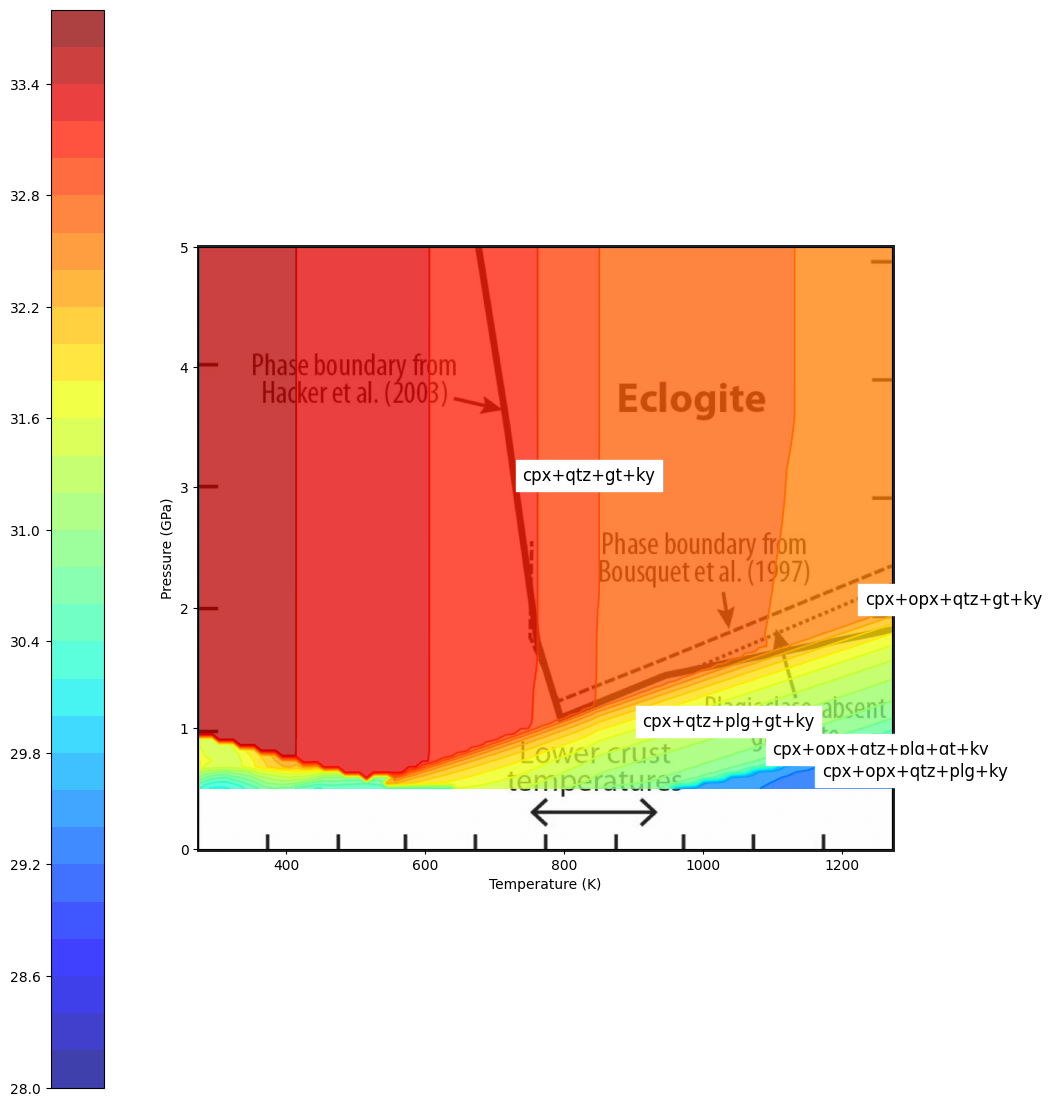

In [11]:
from matplotlib import pyplot as plt
bdfdiag = plot_reaction_grid(
    rxn, 
    grid, 
    plot_phases=True,
    figure_background="figures/krystopowicz-a4.png",
    figure_xlim = [273.,1273.],
    figure_ylim = [0., 5.,]
)
bdfdiag.plot_rho_contours()
plt.savefig('figs/density-krystopowicz.pdf')

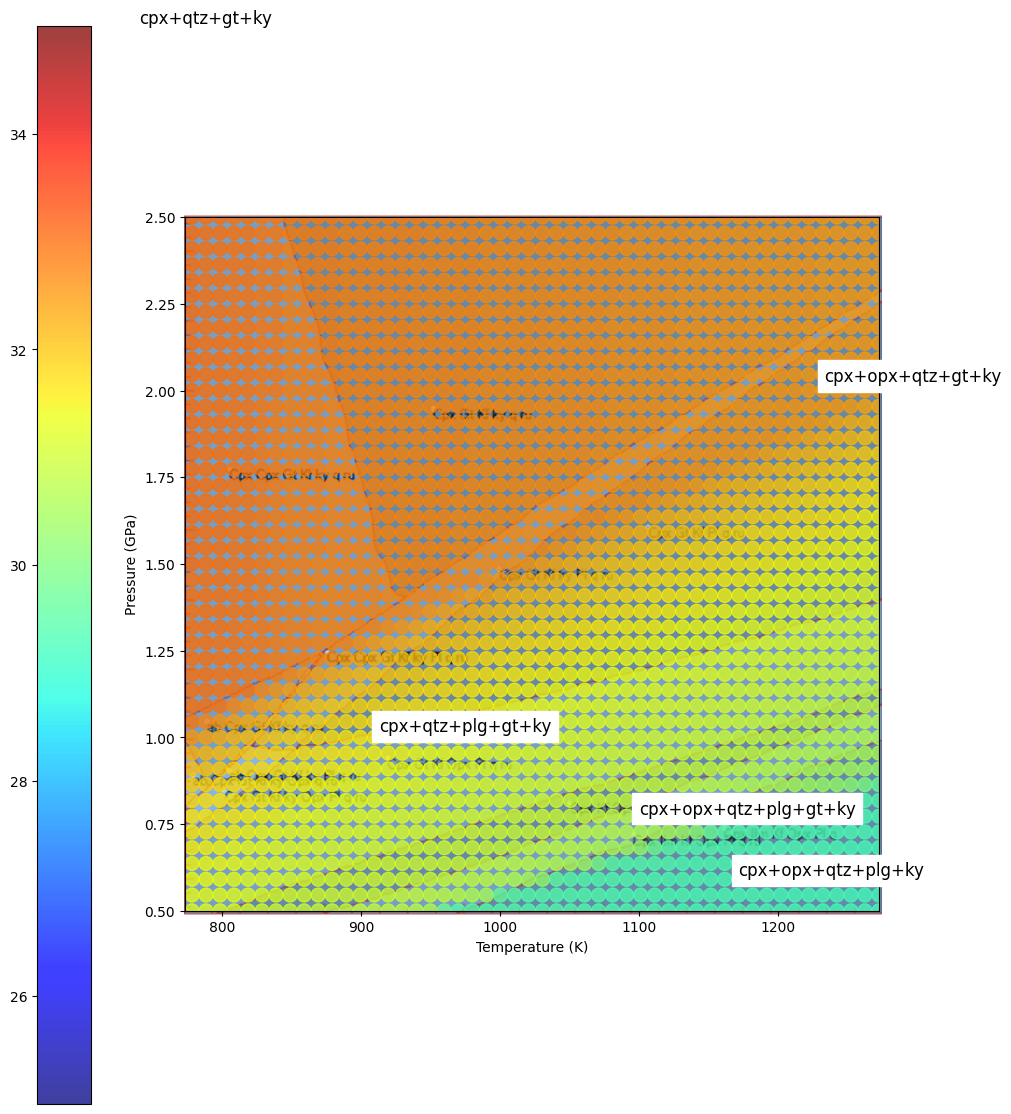

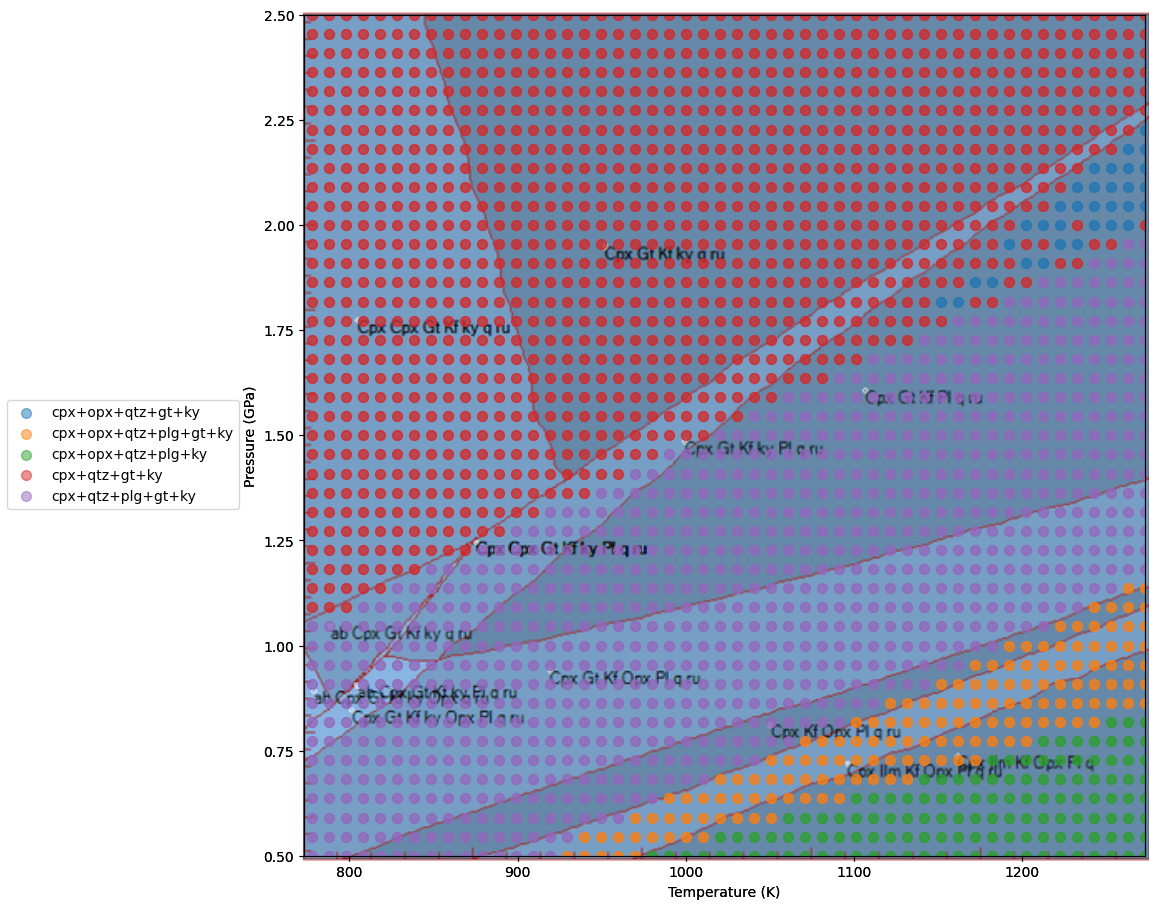

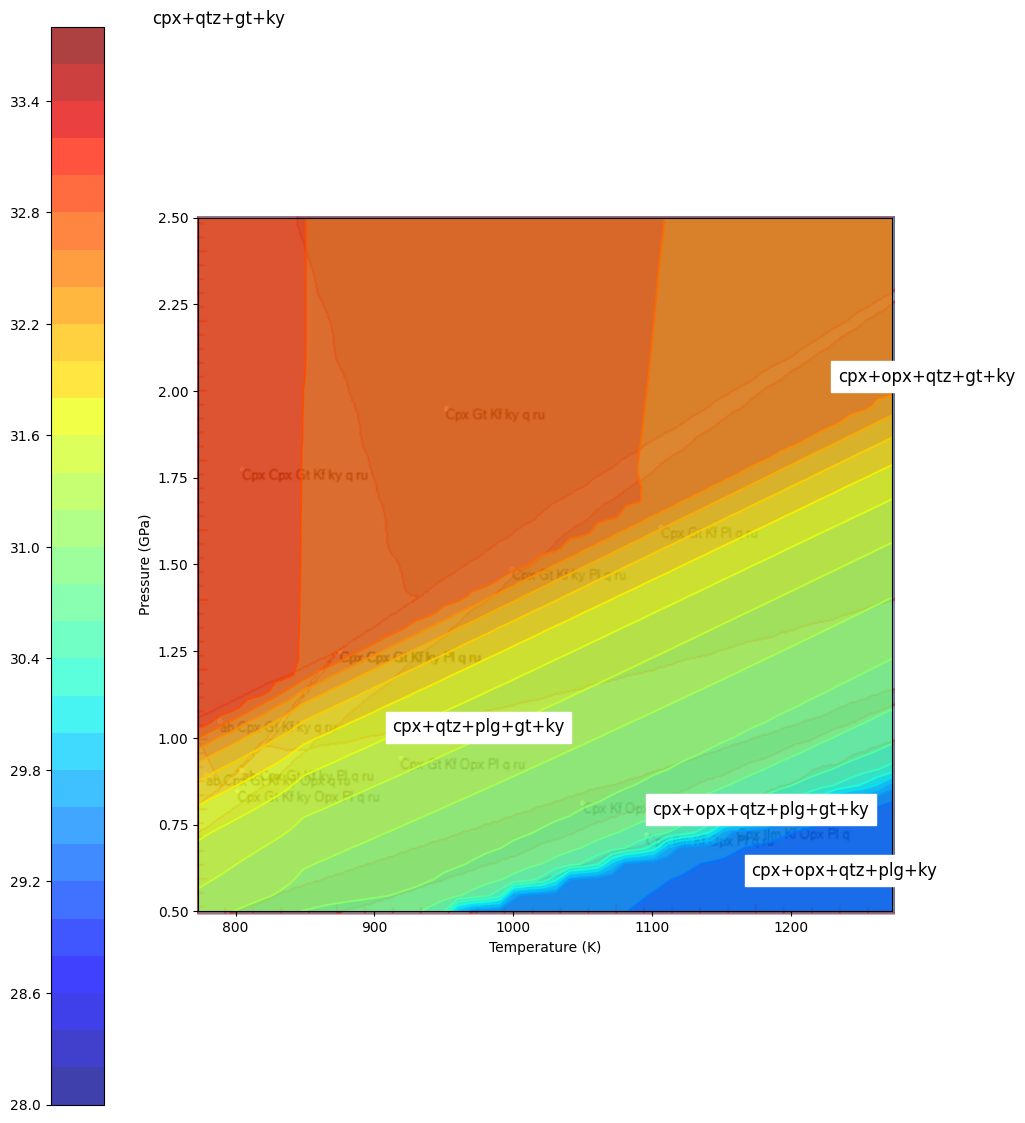

In [13]:
bdfdiag = plot_reaction_grid(
    rxn,
    grid,
    plot_phases=True,
    figure_background="figures/hp62-cropped.png",
    figure_xlim=[773.0, 1273.0],
    figure_ylim=[0.5, 2.5,],
)
bdfdiag.plot_rho_contours()


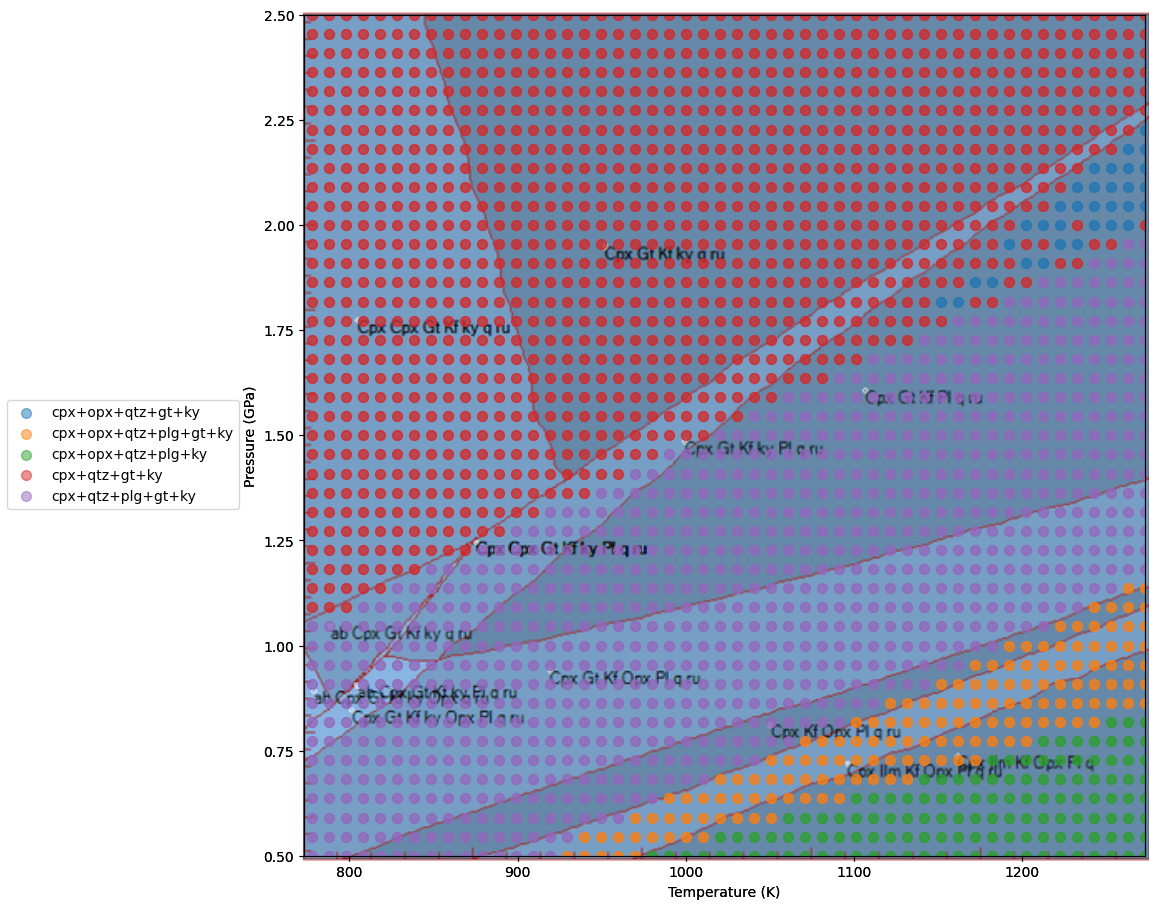

In [14]:
bdfdiag.plot_phases()
plt.savefig('figs/hp62-pseudosection.pdf')

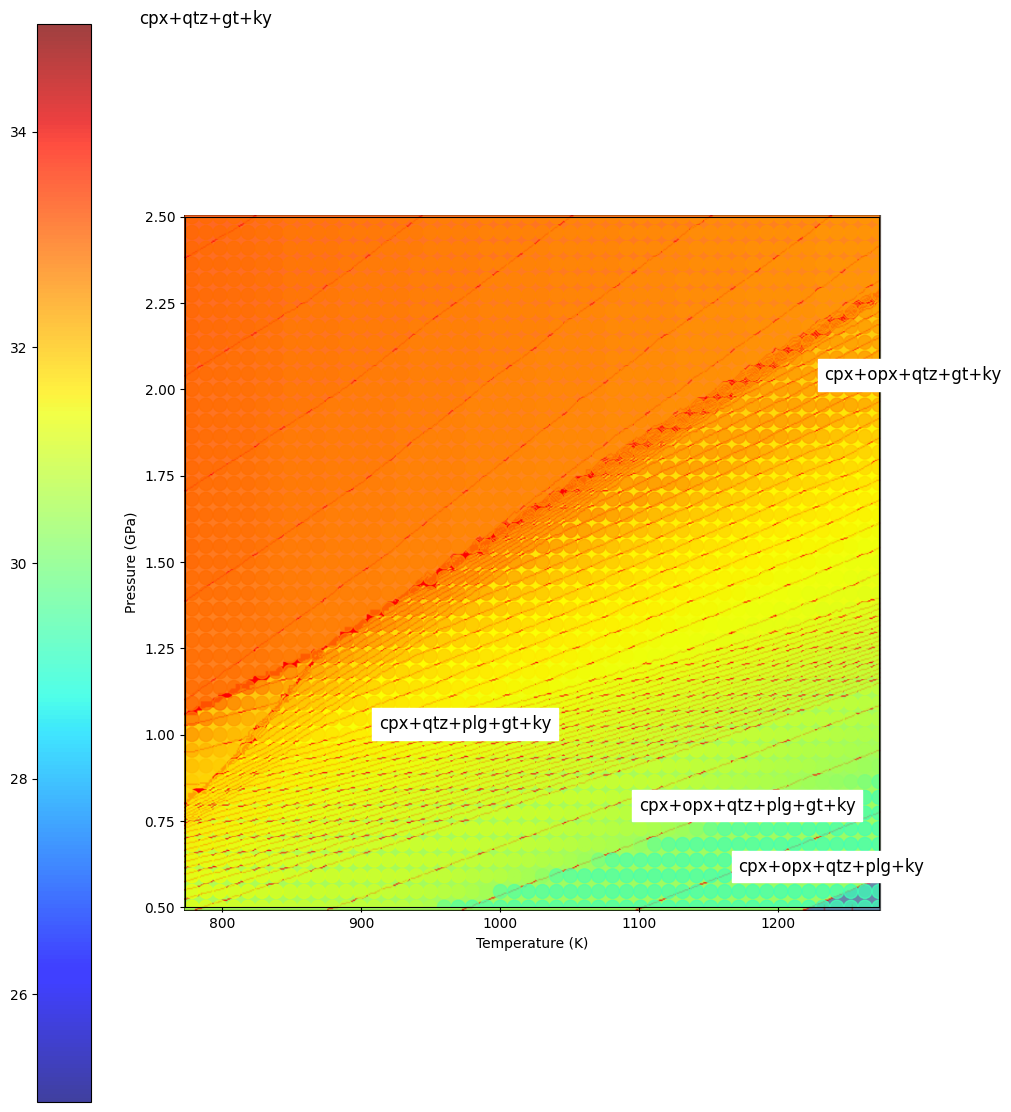

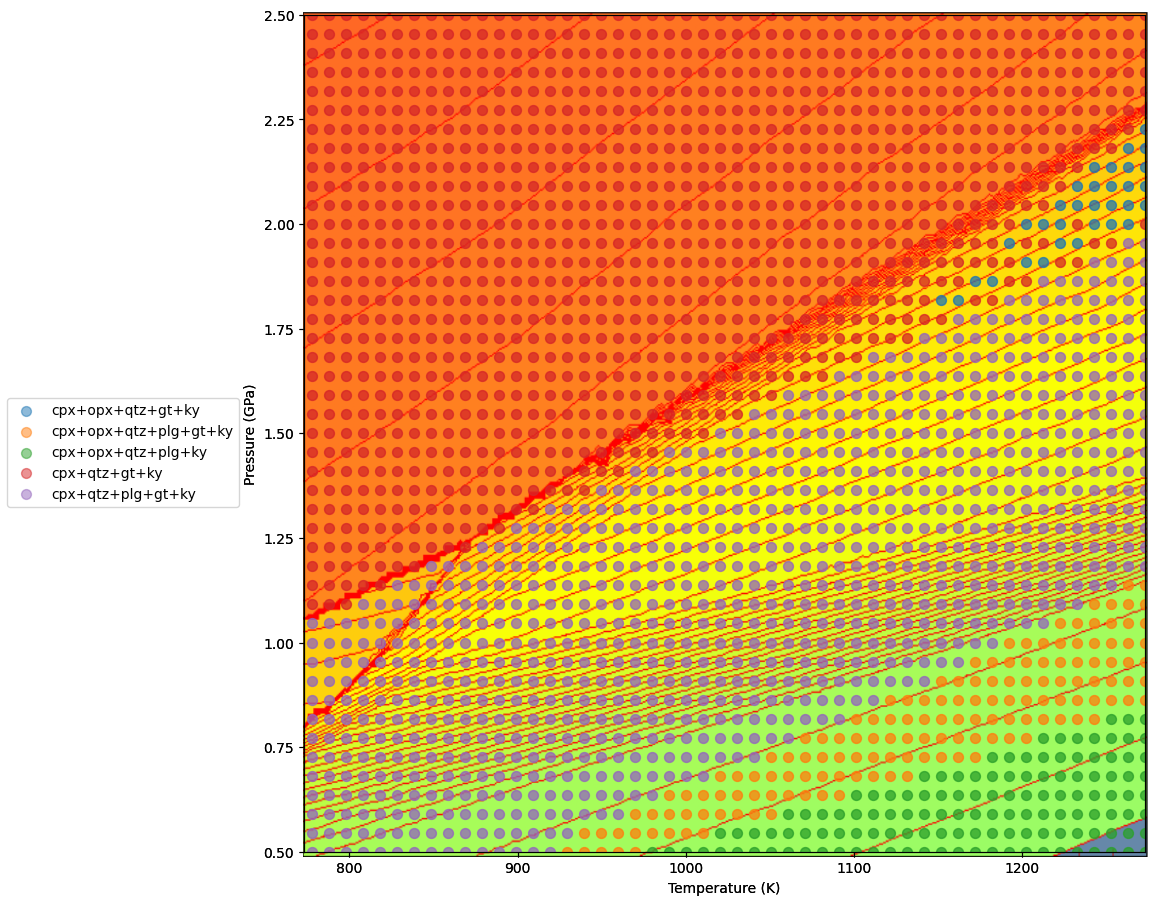

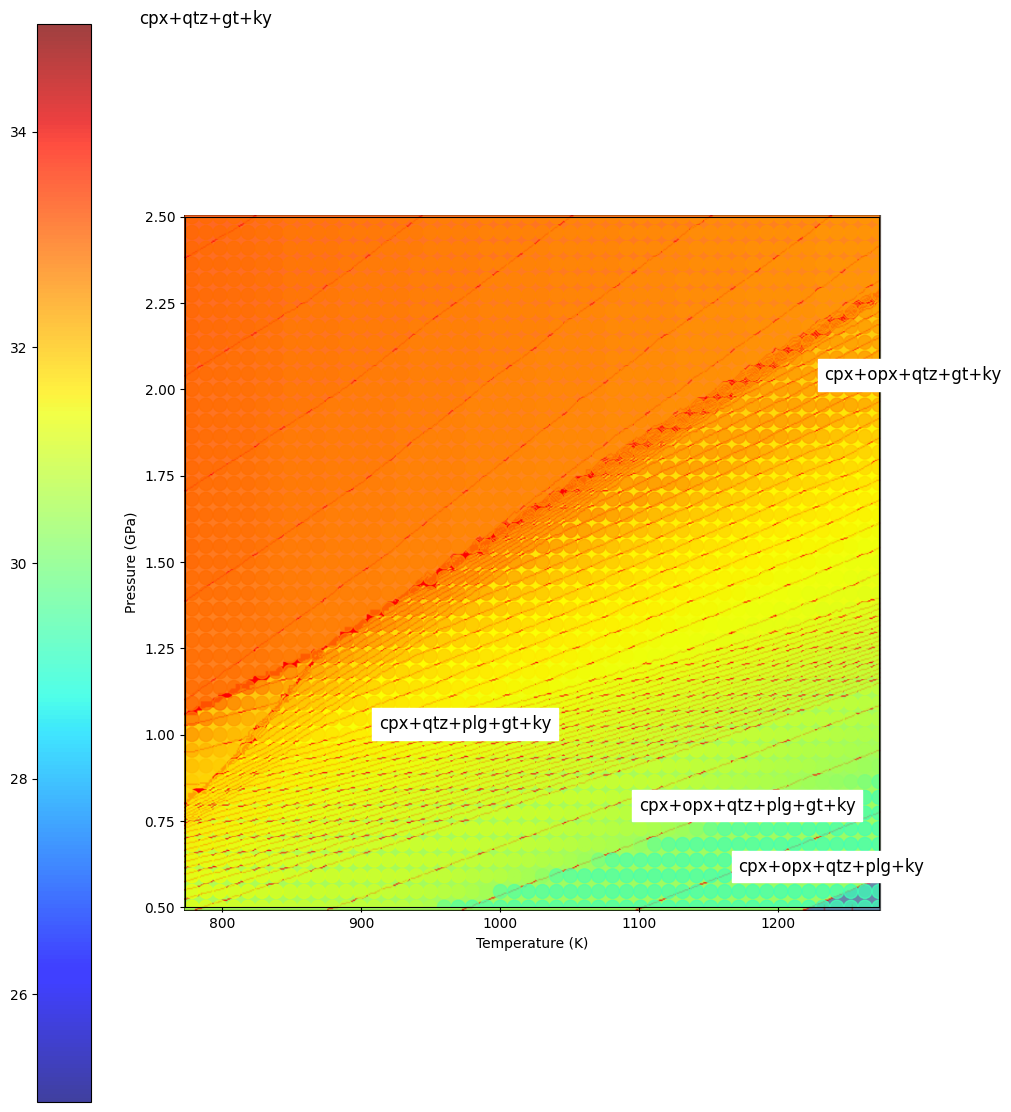

In [15]:
bdfdiag = plot_reaction_grid(
    rxn,
    grid,
    figure_background="figures/hp62-density-cropped.png",
    figure_xlim=[773.0, 1273.0],
    figure_ylim=[0.5, 2.5,],
)

s=bdfdiag.plot_rho()
s.set_clim([25., 35.])
s.set_cmap('jet')
plt.savefig('figs/hp62-density.pdf')

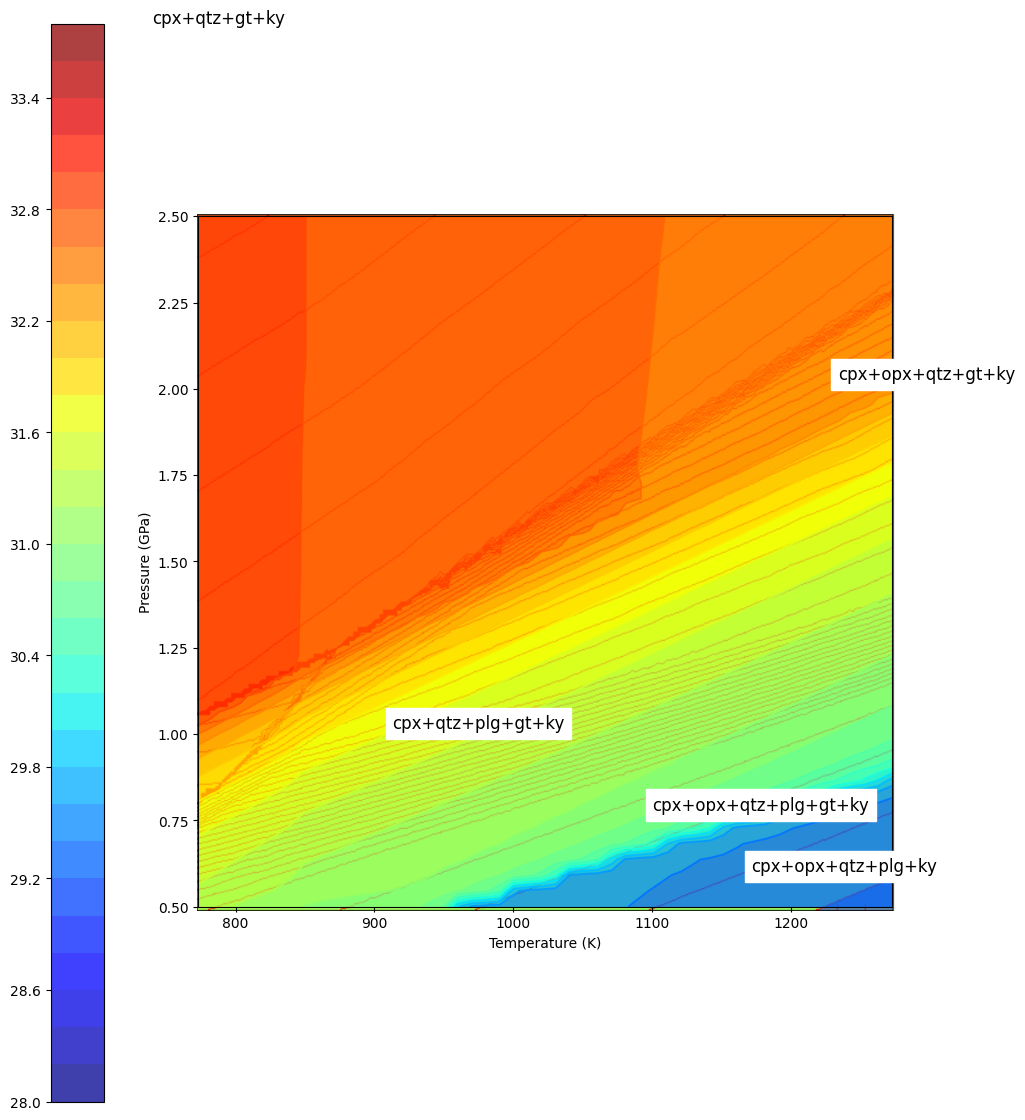

In [16]:
s=bdfdiag.plot_rho_contours()
plt.savefig('figs/hp62-density-contours.pdf')

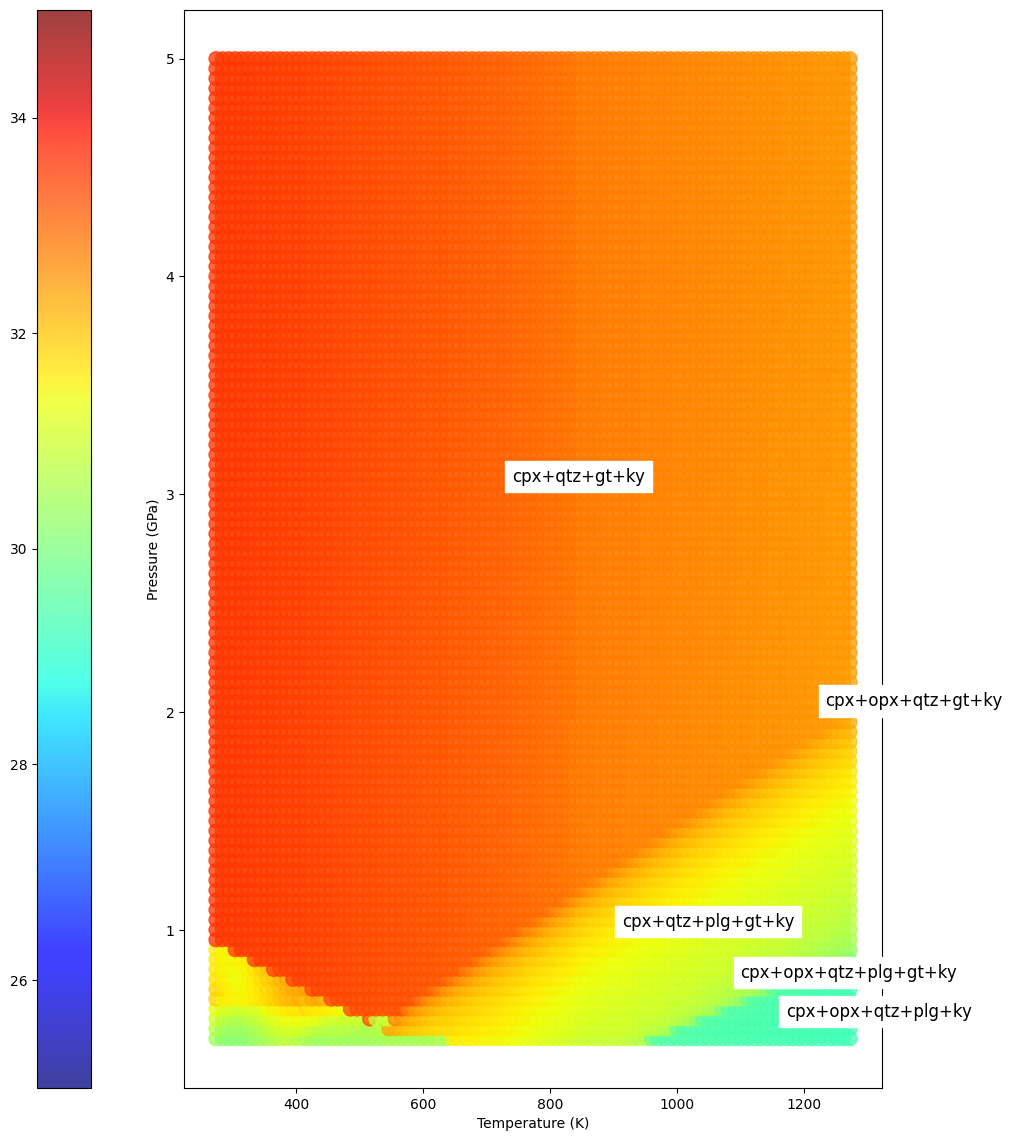

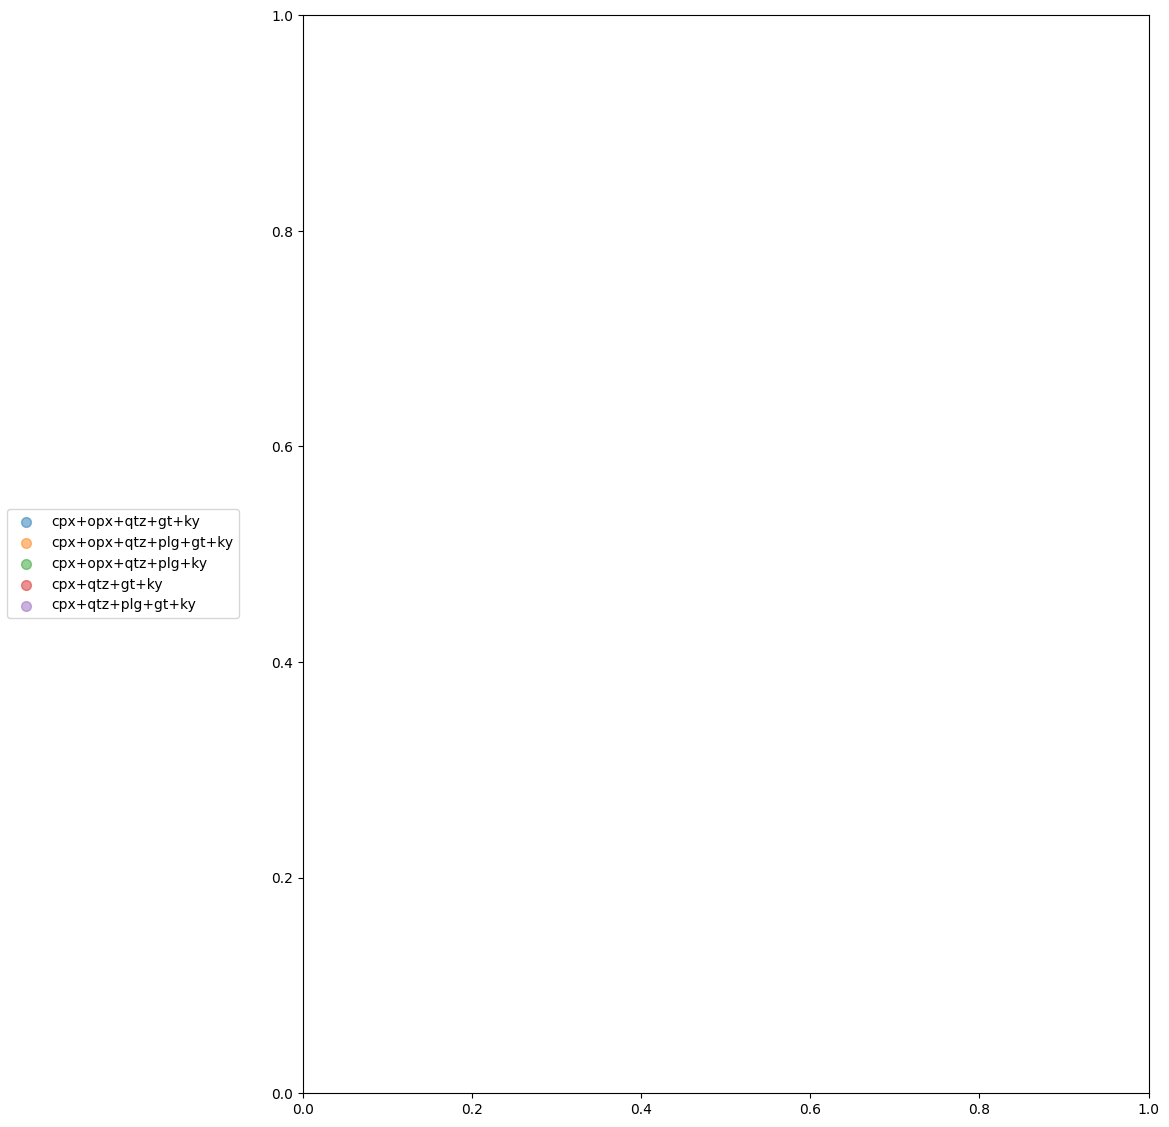

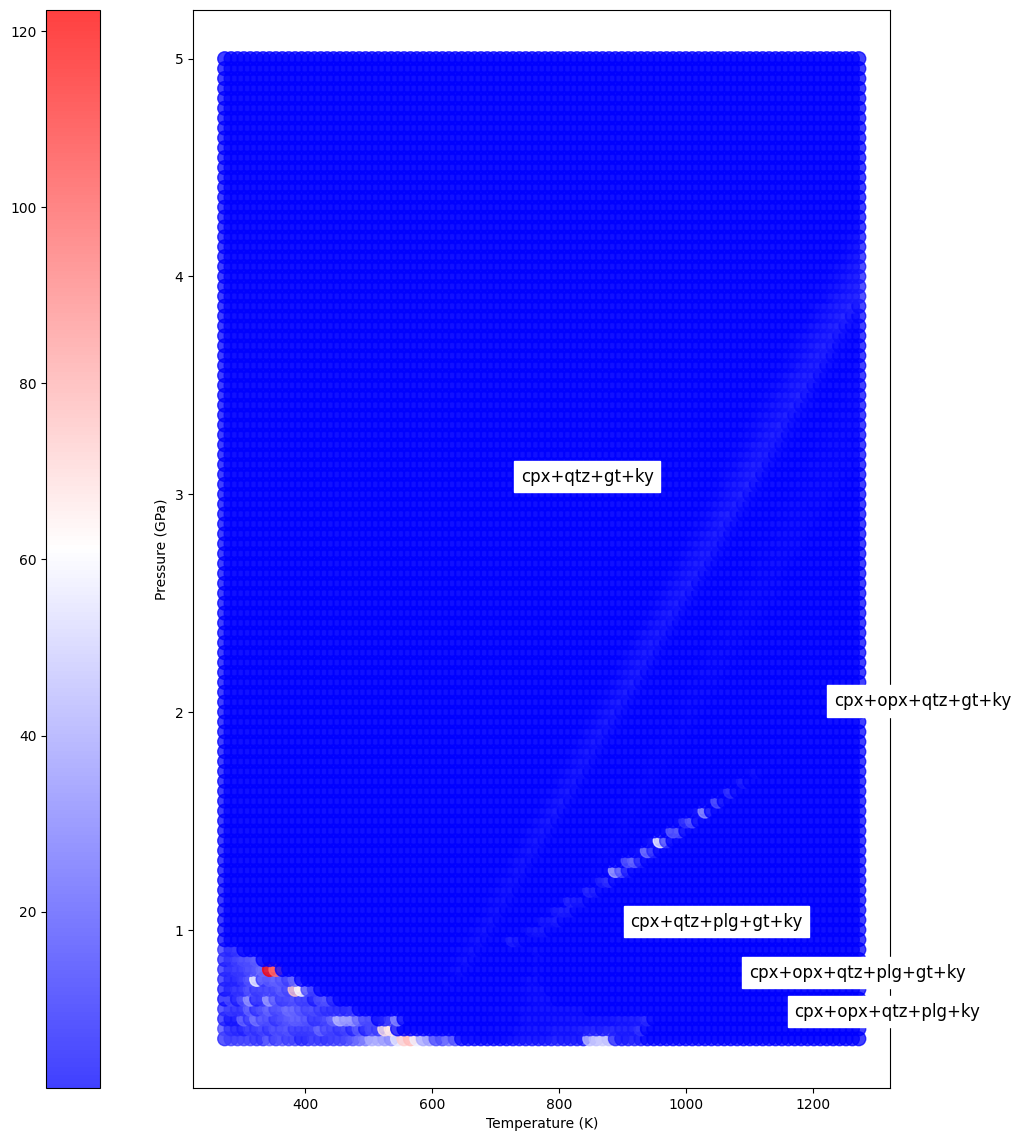

In [23]:
bdfdiag = plot_reaction_grid(rxn,grid)
bdfdiag.plot_stime()